In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler

### Generate the problem / prepare selected datasets

In [2]:
nrows = 20000

In [3]:
numerical_features_index = [0, 2, 4, 10, 11, 12]

data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
y_train = data_train.loc[:, data_train.columns[-1]]
gender_train = data_train.loc[:, data_train.columns[9]]


data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
y_test = data_test.loc[:, data_train.columns[-1]]
gender_test = data_test.loc[:, data_test.columns[9]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_test.drop(data_test.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)
data_test = data_test.astype(np.float64)



gender_train = gender_train.apply(lambda x: x.strip())
gender_test = gender_test.apply(lambda x: x.strip())

In [4]:
data_train.shape

(20000, 6)

In [5]:
data_train.drop_duplicates(inplace=True)
y_train = y_train.loc[data_train.index]
gender_train = gender_train.loc[data_train.index]

assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]

In [6]:
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.fit_transform(y_test).ravel()

In [7]:
gender_binarizer = LabelBinarizer()
gender_binary = gender_binarizer.fit_transform(gender_test.values).ravel()

In [8]:
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [10]:
random_seed=777 #tri topora

In [11]:
clf_base = LogisticRegression(random_state=random_seed)

In [12]:
clf = clone(clf_base)

clf.fit(data_train, y_train)

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=777, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
print('Initial accuracy of classification: {}'.format(accuracy_score(y_test, clf.predict(data_test))))

Initial accuracy of classification: 0.8131564400221116


In [14]:
male_entries_index = gender_train[gender_train == 'Male'].index
female_entries_index = gender_train[gender_train == 'Female'].index

male_entries_test_index = gender_test[gender_test == 'Male'].index
female_entries_test_index = gender_test[gender_test == 'Female'].index

In [15]:
n0 = data_train[gender_train == 'Male'].shape[0]
n1 = data_train[gender_train == 'Female'].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0

emperical_histogram_female = np.ones_like(female_entries_index) / n1

In [16]:
C = ot.dist(data_train[gender_train == 'Male'], data_train[gender_train == 'Female'])

In [17]:
coupling1 = ot.sinkhorn(emperical_histogram_male, emperical_histogram_female, C, reg=0.1, numItermax=10000000, verbose=True)

It.  |Err         
-------------------
    0|9.241773e-05|
   10|2.498800e-05|
   20|1.319898e-05|
   30|8.482051e-06|
   40|6.072045e-06|
   50|4.822213e-06|
   60|4.127460e-06|
   70|3.696102e-06|
   80|3.409614e-06|
   90|3.243020e-06|
  100|3.160369e-06|
  110|3.117404e-06|
  120|3.089335e-06|
  130|3.062097e-06|
  140|3.046639e-06|
  150|3.039519e-06|
  160|3.035401e-06|
  170|3.031626e-06|
  180|3.012587e-06|
  190|2.994350e-06|
It.  |Err         
-------------------
  200|2.974117e-06|
  210|2.939404e-06|
  220|2.902875e-06|
  230|2.857764e-06|
  240|2.813211e-06|
  250|2.772829e-06|
  260|2.739239e-06|
  270|2.704534e-06|
  280|2.653099e-06|
  290|2.551462e-06|
  300|2.440627e-06|
  310|2.324485e-06|
  320|2.191222e-06|
  330|2.065517e-06|
  340|1.929654e-06|
  350|1.812560e-06|
  360|1.726666e-06|
  370|1.658522e-06|
  380|1.595775e-06|
  390|1.540130e-06|
It.  |Err         
-------------------
  400|1.490737e-06|
  410|1.447432e-06|
  420|1.402726e-06|
  430|1.355307e-06|
  4

/home/grapefroot/datascience3/lib/python3.6/site-packages/ot/bregman.py:371: RuntimeWarning: overflow encountered in true_divide
  u = 1. / np.dot(Kp, v)


In [18]:
coupling = ot.emd(emperical_histogram_male, emperical_histogram_female, C, numItermax=1000000000)

In [19]:
def confusion_matrix(predictions, protected_attribute):
    n = predictions.shape[0]
    a = np.sum((predictions == 0) & (protected_attribute == 0)) / n
    b = np.sum((predictions == 1) & (protected_attribute == 0)) / n
    c = np.sum((predictions == 0) & (protected_attribute == 1)) / n
    d = np.sum((predictions == 1) & (protected_attribute == 1)) / n
    return a, b, c, d
      
def balanced_error_rate(y_true, y_pred, protected_attributes):
    pass

In [20]:
def likelihood_ratio(y_predicted, protected):
    #following https://arxiv.org/pdf/1412.3756.pdf
    a, b, c, d = confusion_matrix(y_predicted, protected)
    return d * (a + c) / c / (b + d)

In [21]:
def disparate_impact(y_true, protected):
    return 1. / likelihood_ratio(y_true, protected)

In [22]:
def construct_map(weights, data_first, data_second, coupling):
    weight_1, weight_2 = weights
 #   print(weights)
    n0 = data_train[gender_train == 'Male'].shape[0]
    n1 = data_train[gender_train == 'Female'].shape[0]
    mapped_class_0 = weight_1 * data_first  + n0 * weight_2 * (coupling @ data_second)
    mapped_class_1 = weight_1 * n1 * (coupling.T @ data_first) + weight_2 * data_second
    return mapped_class_0, mapped_class_1

In [23]:
def full_repair(data_first, data_second, y, coupling, weights=[0.5, 0.5]):
    mapped_class_0, mapped_class_1 = construct_map(weights, data_first, data_second, coupling)
    y_mapped_0 = y[gender_train == 'Male']
    y_mapped_1 = y[gender_train == 'Female']
    return np.concatenate((mapped_class_0, mapped_class_1)), np.concatenate((y_mapped_0, y_mapped_1))

In [24]:
def partial_repair(interpolation_weight, data_first, data_second, y, coupling, weights=[0.5, 0.5]):
    mapped_class_0, mapped_class_1 = construct_map(weights, data_first, data_second, coupling)
    y_mapped_0 = y[gender_train == 'Male']
    y_mapped_1 = y[gender_train == 'Female']
    return np.concatenate(
        (interpolation_weight * mapped_class_0 + (1 - interpolation_weight) * data_first,
         interpolation_weight * mapped_class_1 + (1 - interpolation_weight) * data_second)), np.concatenate((y_mapped_0, y_mapped_1))

In [25]:
def random_repair(interpolation_weight, theta, data_first, data_second, y, coupling, weights=[0.5, 0.5]):
    mapped_class_0, mapped_class_1 = construct_map(weights, data_first, data_second, coupling)
    y_mapped_0 = y[gender_train == 'Male']
    y_mapped_1 = y[gender_train == 'Female']
    
    selector_0 = np.random.binomial(1, theta, size=data_first.shape[0]) == 1
    selector_1 = np.random.binomial(1, theta, size=data_second.shape[0]) == 1
    
    data_first[selector_0] = interpolation_weight * mapped_class_0[selector_0] + (1 - interpolation_weight) * data_first[selector_0]
    data_second[selector_1] = interpolation_weight * mapped_class_1[selector_1] + (1 - interpolation_weight) * data_second[selector_1]
    
    return np.concatenate(
    (interpolation_weight * mapped_class_0 + (1 - interpolation_weight) * data_first,
     interpolation_weight * mapped_class_1 + (1 - interpolation_weight) * data_second)), np.concatenate((y_mapped_0, y_mapped_1))

In [26]:
from tqdm import tqdm_notebook

In [27]:
print('class 0 size {}'.format(data_train[gender_train == 'Female'].shape))
print('class 1 size {}'.format(data_train[gender_train == 'Male'].shape))

class 0 size (6603, 6)
class 1 size (13309, 6)


In [28]:
num = 100

In [29]:
acs = []
dims = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = partial_repair(repair_value, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_train, coupling)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs.append(accuracy_sc)
    dims.append(disparate_im)

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
acs_1 = []
dims_1 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = partial_repair(repair_value, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_train, coupling1)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs_1.append(accuracy_sc)
    dims_1.append(disparate_im)

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
acs_2 = []
dims_2 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = random_repair(repair_value, 0.5, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_train, coupling)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs_2.append(accuracy_sc)
    dims_2.append(disparate_im)

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
acs_3 = []
dims_3 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = random_repair(repair_value, 0.5, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_train, coupling1)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs_3.append(accuracy_sc)
    dims_3.append(disparate_im)

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


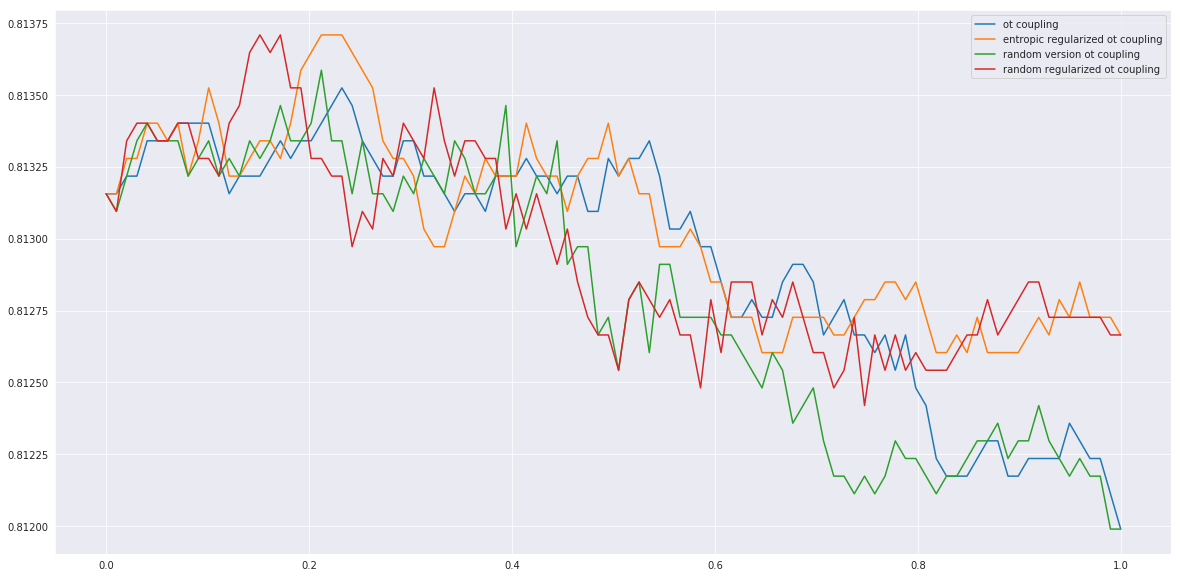

In [33]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 10))
    plt.plot(np.linspace(0, 1, num), acs, label='ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_1, label='entropic regularized ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_2, label='random version ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_3, label='random regularized ot coupling')
    plt.legend()

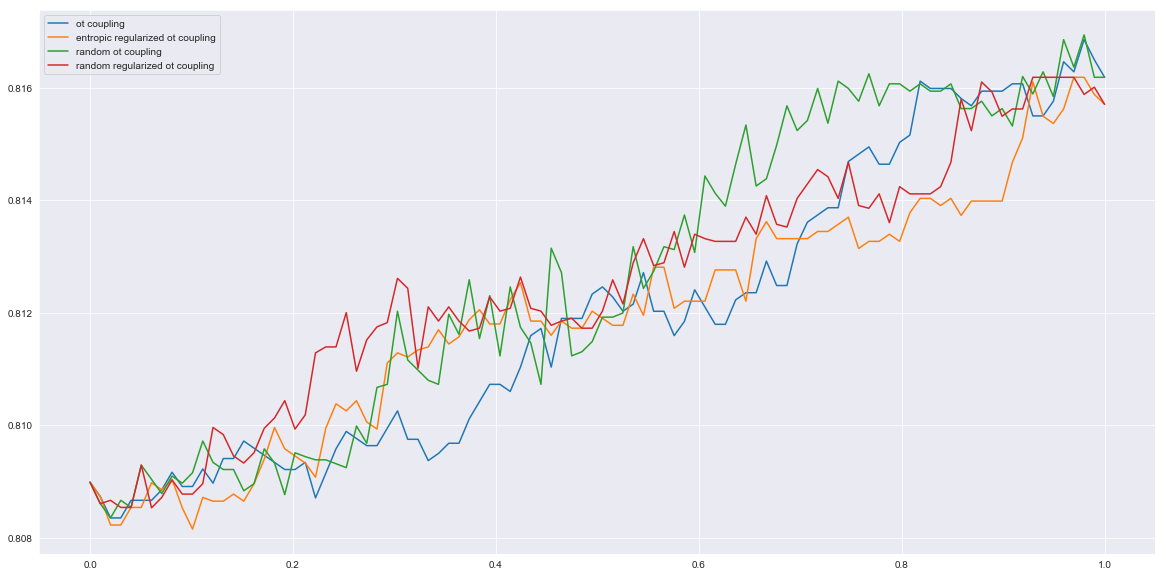

In [34]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 10))
    plt.plot(np.linspace(0, 1, num), dims, label='ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_1, label='entropic regularized ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_2, label='random ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_3, label='random regularized ot coupling')
    plt.legend()
    plt.show()

In [35]:
X_new, y_new = partial_repair(0.6, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_train, coupling1)

In [41]:
disparate_impact(clf.predict(data_test), gender_binary)

0.8089868588384908

In [42]:
clf1 = clone(clf_base)
clf1.fit(X_new, y_new)

accuracy_score(y_test, clf1.predict(data_test))

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8127879122903998

In [43]:
disparate_impact(clf1.predict(data_test), gender_binary)

0.8123319258685882

### Show that different solutions for the same transporation problem can have different fairness

### Explore how the regularized barycenters are defined, try to apply them to the problem

### Use the regularized transport maps instead of usual ones